In [1]:
class Models:
    def __init__(self,β:float,γ:float,rent:float,nw:int,w_max:float,w_min:float,grid_w:"np.ndarray[np.float64]"):
        # パラメータ
        self.β = β # 割引因子
        self.γ = γ # 相対的危険回避度

        # 要素価格
        self.rent = rent # 純利子率

        # グリッド
        self.nw = nw # 所得グリッドの数
        self.w_max = w_max # 所得グリッドの最大値
        self.w_min = w_min # 所得グリッドの最小値 
        self.grid_w = grid_w # 所得グリッド

In [2]:
def Calibration():
    # パラメータはここで設定をする
    β = 0.985**30
    γ = 2.0
    rent = 1.025**30 - 1.0
    nw = 10
    w_max = 1.0
    w_min = 0.1

    grid_w = np.linspace(w_min,w_max,nw)

    return Models(β, γ, rent, nw, w_max, w_min, grid_w)

In [3]:
def CRRA(cons,γ):
    if γ != 1.0:
        return cons**(1.0 - γ) / (1.0 - γ)
    else:
        return np.log(cons)

In [4]:
def mu_CRRA(cons,γ):
    return cons**(-γ)

In [5]:
# 使う関数を呼び出す
import numpy as np # 配列を扱うためのパッケージ
import matplotlib.pyplot as plt # プロットを行うためのパッケージ
# !pip install japanize_matplotlib
import japanize_matplotlib # プロットで日本語を使うためのパッケージ
from scipy import optimize # Python上の Optimization Tool
import time # 計測時間をはかるためのパッケージ

# 操作変数を連続変数にする：最適化

- 状態変数と操作変数をともに離散化するアプローチは、離散化するグリッドの数を節約すると精度が非常に悪くなる


- 本来の解である(4)式は線形であるはずなのに、$J=40$のときの貯蓄関数は直線ではない


- そこで、もう少し洗練されたアプローチを考える：状態変数は離散化するが、操作変数については連続的な値をとる

- 経済主体の最適化問題は、各$w_{i}$ for $i=1,\dots,I$について、

$$
  \max_{a} \frac{[w_{i}-a]^{1-\gamma}}{1-\gamma}+\beta\frac{[(1+r)-a]^{1-\gamma}}{1-\gamma} \tag{6}
$$

となるが、操作変数$a\in\mathbb{R}$については任意の実数をとりうる

In [6]:
def obj_two_period(a,w_val,params):
    """
    所得wを所与として、2期間モデルの生涯効用を返す関数
    @author Tokuma Suzuki(Julia ver)
    
    # インプット
    `a::Real`: 貯蓄水準
    `w_val::Real`: 所得水準
    `m::Models`: パラメータを含む構造体(βとかγ：カリブレーションの場所で設定済み)

    # アウトプット 
    生涯効用:
    """
    # 1期目の効用
    if w_val - a > 0.0:
        util_y = CRRA(w_val - a, params.γ)
    else:
        util_y = -1000000.0 #負の消費に対するペナルティ
    
    # 2期目の割引効用
    util_o = params.β*CRRA((1.0 + params.rent)*a, params.γ)

    # optimizeが最小値を探すので、マイナスをかけることで最適な値を求める。
    return  -1.0*(util_y + util_o)

- どうやって(6)式の解を得ればよいのであろうか？


- とりあえず、最適化(optimization)と呼ばれるライブラリを使う
    - MATLABであれば、Optimization Toolboxにある関数fminsearchやfminbnd
    - Pythonであれば、SciPyにある関数fmin
    - Juliaであれば、Optim.jlにある関数

- アルゴリズム


1. パラメータを設定する（カリブレーション）。

2. $w_{i}\in\{w_{1},\dots,w_{I}\}$を離散化した若年期の所得とする。

3. 各$w_{i}$について、(6)式を最大にするような$a$を探し出す。各言語の最適化関数を利用する。

4. 得られた各$w_{i}$と$a$の組み合わせが貯蓄関数である。

In [7]:
# 事前に設定しておいたパラメータをparamsという一つの変数にまとめる：struct
params = Calibration()

# 空の変数を用意
a_gs = np.zeros(params.nw)
from scipy.optimize import Bounds

# 各wについて目的関数を最大にするような貯蓄水準aを求める
for (w_ind,w_val) in enumerate(params.grid_w):
    
    # 関数obj_two_periodを再定義
    # "aのみをargument"とする関数を作る：optimizeの中に入れる関数はパラメータを与えたもとでの関数である必要あり
    obj_two_period1 = lambda a: obj_two_period(a,w_val,params)

    # ブレント法(Brents' method)により計算
    # 使い方：aの最適値を探す範囲を指定→[w_val*0.01, w_val*2.0]
    # この範囲内で関数を最小(最大)にするaを見つけ出すアルゴリズム
    
    res = optimize.fminbound(obj_two_period1,w_val*0.01,w_val*2.0)
    a_gs[w_ind] = res

- 図は、Pythonの最適化関数scipy.optimize.fminboundを使って、各$w_{i}$における最適な$a$を探してプロットした貯蓄関数。操作変数が取りうる値を連続にすることで、計算精度が大幅に改善された。

In [8]:
# 解析解：(2.4)式
coef1 = (params.β*(1.0 + params.rent))**(-1.0/params.γ)
coef2 = 1.0/(1.0+coef1*(1.0 + params.rent))
a_cfs = coef2*params.grid_w

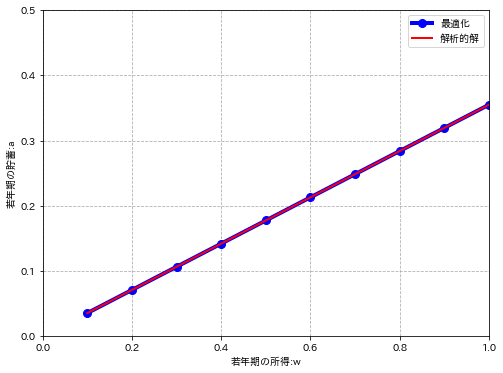

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.grid_w,a_gs,c="b",marker="o",lw=4,ms=8,label="最適化")
ax.plot(params.grid_w,a_cfs,c="r",lw=2,label="解析的解")
ax.set(xlabel="若年期の所得:w",ylabel="若年期の貯蓄:a",xlim=(0,1.0),ylim=(0,0.5))
ax.legend(loc="upper right")
ax.grid(ls="--")
plt.show()

# 一階条件を使う：求根アルゴリズム

## 非線形方程式のゼロ点を探す

- 予算制約を代入した後の2期間モデルの一階条件(3)は、

$$
  u'(w-a) = (1+r)\beta u'((1+r)a) \tag{6}
$$

となる（オイラー方程式）。

- 前節と同様に、$w_{i}$については離散化して考えると、

$$
  u'(w_{i}-a) = (1+r)\beta u'((1+r)a)
$$

なので、未知の変数は$a$のみである。

- (6)式を、

$$
  R(w_{i}) = (1+r)\beta \frac{u'((1+r)a)}{u'(w_{i}-a)} -1 \tag{7}
$$

と書き換えると、ある$w_{i}$のもとで$R(w_{i}) =0$となるような$a$、すなわち残差関数(residual function)のゼロ点を探す問題(root-finding problem：求根問題)に読み替えることができる。

- 残差関数は複雑の形をした非線形方程式の可能性


- 非線形方程式のゼロ点を探す手法に関する研究は長い歴史を持つため、既に様々なアプローチが存在
    - MATLABであれば、fzero
    - Pythonであれば、SciPyにある関数fsolve
    - Juliaであれば、Optim.jlにある関数

- アルゴリズム


1. パラメータを設定する（カリブレーション）。

2. $w_{i}\in\{w_{1},\dots,w_{I}\}$を離散化した若年期の所得とする。

3. 各$w_{i}$について、(8)式がゼロになる$a$を探し出す。ゼロ点を探すためには、各言語に備わっている（あるいは外部ライブラリの）求根アルゴリズムを利用する。

4. 得られた各$w_{i}$と$a$の組み合わせが貯蓄関数である。

In [10]:
def resid_two_period(a,w_val,params):
    """
    2期間モデルの1階条件の残差を求める

    # インプット
    `a`: 貯蓄水準
    `w_val`: 所得水準
    `params`: パラメータを含む構造体

    # アウトプット
    残差
    """

    # オイラー方程式の左辺：若年期の限界効用
    if w_val - a > 0.0:
        mu1 = mu_CRRA(w_val-a, params.γ)
    else:
        mu1 = 10000.0

    # 老年期の限界効用
    mu2 = mu_CRRA((1.0 + params.rent)*a, params.γ)

    # 残差(residual)
    return params.β*(1.0 + params.rent)*(mu2/mu1) - 1.0

In [11]:
# %% 残差をプロットしてみる(最終的な結果には不要な計算)：図3
# resid1 = zeros(na, 1);
# resid2 = zeros(na, 1);
# resid3 = zeros(na, 1);

# % w = 0.5
# w = 0.5;
# for i = 1:na
#     resid1(i) = resid_two_period(grid_a(i));
# end

# % w = 0.8
# w = 0.8;
# for i = 1:na
#     resid2(i) = resid_two_period(grid_a(i));
# end

# % w = 1.0
# w = 1.0;
# for i = 1:na
#     resid3(i) = resid_two_period(grid_a(i));
# end

# grid_zero = zeros(na,1);

In [12]:
# figure;
# plot(grid_a, resid1, '-', 'color', 'blue', 'MarkerEdgeColor', 'b', 'MarkerSize', 12, 'linewidth', 3); hold('on');
# plot(grid_a, resid2, '-.', 'color', 'green', 'MarkerEdgeColor', 'g', 'MarkerSize', 12, 'linewidth', 3);
# plot(grid_a, resid3, '--', 'color', 'red', 'MarkerEdgeColor', 'r', 'MarkerSize', 12, 'linewidth', 3);
# plot(grid_a, grid_zero,'-', 'color', 'black', 'linewidth', 1); hold('off');
# xlabel('若年期の貯蓄：a', 'Fontsize', 16);
# ylabel('残差：R(w)', 'Fontsize', 16);
# xlim([0.1, 0.5]);
# ylim([-1, 1]);
# legend('w=0.5', 'w=0.8', 'w=1', 'Location', 'NorthEast');
# set(gca,'Fontsize', 16);
# grid on;

In [13]:
# パラメータを設定
params = Calibration()

# 空っぽの変数を用意：policy functionの器
a_nl = np.zeros(params.nw)

# 実際に各w_{i}のもとで、残差関数がゼロになるようなaを探す
for (w_ind,w_val) in enumerate(params.grid_w):

    # 1変数のfunctionにする
    resid_two_period1 = lambda a: resid_two_period(a, w_val, params)

    # 0.01はゼロ点を探す際の初期値
    res = optimize.fsolve(resid_two_period1,x0=0.01)
    a_nl[w_ind] = res[0]

# print(a_nl)

In [14]:
# 解析解
# テキストの(2.4)式
coef1 = (params.β*(1.0+params.rent))**(-1.0/params.γ)
coef2 = 1.0/(1.0+coef1*(1.0+params.rent))
a_cfs = coef2*params.grid_w

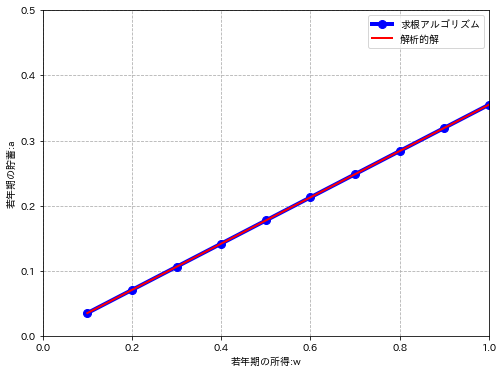

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.grid_w,a_nl,c="b",marker="o",lw=4,ms=8,label="求根アルゴリズム")
ax.plot(params.grid_w,a_cfs,c="r",lw=2,label="解析的解")
ax.set(xlabel="若年期の所得:w",ylabel="若年期の貯蓄:a",xlim=(0,1.0),ylim=(0,0.5))
ax.legend(loc="upper right")
ax.grid(ls="--")
plt.show()

## 射影法

- 最適化と求根アルゴリズムを使った手法は、現在の資産水準を離散個に区切って、そのうえでの最適貯蓄を計算するという点で共通している


- それに対して射影法(projection method)では、政策関数全体を近似する

- 例えば、貯蓄関数を$N$次の多項式(polynomials)

$$
  \hat{g}(w;\mathbb{\theta}) = \sum_{n=0}^{N} \theta_{n}w^{n} \tag{8}
$$

で近似したいとしよう


- (4)式から、$a=\theta_{1}w$の形式で表現できることがここでは分かっている

- しかし、一般的には政策関数はより複雑な形状をしている


- 射影法は、オイラー方程式を満たす政策関数を探すという問題を、多項式における未知の係数ベクトル$\mathbb{\theta}=\{\theta_{n}\}_{n=0}^{N}$を探す問題に置き換える


- より一般的には、多項式は

$$
  \hat{g}(w;\mathbb{\theta}) = \sum_{n=0}^{N} \theta_{n}\Psi_{n}(w) \tag{9}
$$

と書くことが出来る。このとき、$\Psi_{n}(w)$は基底関数(basis function)と呼ばれる。

- (9)式が真の政策関数をうまく近似しているのであれば、この式を残差関数に代入した場合の残差はゼロに近いはずである。すなわち、

$$
  R(w;\mathbb{\theta}) = \beta(1+r) \frac{u'((1+r)\hat{g}(w;\mathbb{\theta}))}{u'(w-\hat{g}(w;\mathbb{\theta}))} -1 = 0
$$

が「あらゆる$w$」で成立している必要がある


- 実際には、$R(w;\mathbb{\theta})$が「十分に」ゼロに近ければよい

- 距離関数$\rho$(metric fuction)を導入すると、政策関数を探す問題は、

$$
  \hat{\mathbb{\theta}} = \text{arg}\min_{\theta}\rho(R(w;\mathbb{\theta}),0)
$$

を探す問題に置き換えることができる


- ここでは任意の評価点を取って、そこでの残差（の絶対値）がゼロに近くなる係数ベクトル$\theta$を探す。これを選点法(collocation method)と呼ぶ

<!--
$$
  \rho(R(w;\mathbb{\theta}),0) = \sum_{i=1}^{I}|R(w_{i};\mathbb{\theta})|
$$
-->

- アルゴリズム


1. パラメータを設定する（カリブレーション）。

2. 選点(collocation)$w_{i}\in\{w_{1},\dots,w_{I}\}$を定める。今回はこれまでと同じく$w_{i} \in \{0.1,0.2,0.3,\dots,1.0\}$とする。

3. 近似したい政策関数の関数形を定める。今回は1次関数$\hat{g}(w;\mathbb{\theta}) = \theta_{0} + \theta_{1}w$とする。

4. $\{\theta_{0},\theta_{1}\}$をインプットとして、選点上の残差$R(w_{i},\mathbb{\theta})$を計算して返すサブルーチンを書く。

5. *距離関数を最小化*する$\{\theta_{0}^{*},\theta_{1}^{*}\}$を見つける。

6. 得られた$\hat{g}(w;\mathbb{\theta}^{*}) = \theta_{0}^{*} + \theta_{1}^{*}w$が貯蓄関数である。

<!--5. 残差関数が十分にゼロに近くなる$\{\theta_{0}^{*},\theta_{1}^{*}\}$を見つける。-->

In [16]:
def approx_policy(coef,eval):
    """
    政策関数を多項式によって近似する

    # インプット
    `coef`: 多項式の係数
    `eval`:選点

    # アウトプット
    `next_a`:2期における資産水準
    """
    
    dim_app = len(coef)
    nw = len(eval)
    XX = np.zeros((nw, dim_app))

    for i in range(dim_app):
        XX[:,i] = eval ** i
    
    next_a = XX @ coef.T

    return next_a

In [17]:
def resid_projection(coef, params):
    """
    選点に基づいてオイラー方程式の残差を返す

    # インプット
    `coef`:多項式の係数
    `m::Models`:パラメータを含む構造体

    # アウトプット
    `residual::Vector`:残差
    """

    # 係数coefを使って政策関数を計算
    a = approx_policy(coef, params.grid_w)

    # 各wにおける1期の消費水準を計算
    c1 = params.grid_w - a

    # 2期の消費水準
    c2 = (1.0 + params.rent)*a

    ng = len(c1) # 次元を取り出す
    mu1 = np.zeros(ng) #1期における限界効用
    mu2 = np.zeros_like(mu1) #2期における限界効用
    resid = np.zeros_like(mu1) #残差

    for i in range(ng):
        
        if c1[i] > 0.0:
            mu1[i] = mu_CRRA(c1[i], params.γ)
        else:
            mu1[i] = 10000.0 #負の消費に対するペナルティ
        
        if c2[i] > 0.0:
            mu2[i] = mu_CRRA(c2[i], params.γ)
        else:
            mu2[i] = 10000.0 #負の消費に対するペナルティ
        
        resid[i] = params.β*(1.0 + params.rent)*(mu2[i]/mu1[i]) - 1.0
    

    return resid

In [18]:
params = Calibration()

# % 係数の初期値を当て推量(initial guess)
coef_init = [0.1, 0.35]

# 多項式の次元を決定
resid_projection1 = lambda coef: resid_projection(coef, params)

# レーベンバーグ・マルカート法で非線形最小二乗法を行う
res = optimize.least_squares(resid_projection1,x0=coef_init,method="lm")

# ゼロ点探索によって得た係数を使って政策関数を求める
next_a = approx_policy(res.x, params.grid_w)

# return res.x, res.success , next_a

In [19]:
# 解析解
# テキストの(2.4)式
coef1 = (params.β*(1.0+params.rent))**(-1.0/params.γ)
coef2 = 1.0/(1.0+coef1*(1.0+params.rent))
a_cfs = coef2*params.grid_w

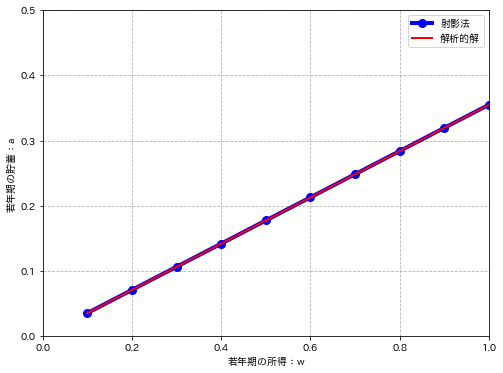

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.grid_w,next_a,c="b",marker="o",lw=4,ms=8,label="射影法")
ax.plot(params.grid_w,a_cfs,c="r",lw=2,label="解析的解")
ax.set(xlabel="若年期の所得：w",ylabel="若年期の貯蓄：a",xlim=(0,1.0),ylim=(0,0.5))
ax.legend(loc="upper right")
ax.grid(ls="--")
plt.show()